In [1]:
import json
from typing import List, Tuple

import pytest
from helpers import make_testframes, print_trace
from pioemu import State, emulate

from conftest import PIO_RX_PROGRAM as pio_code

PioCode = List[int]

# List of breakpoints in the PIO code
BP_BREAK = 3
BP_MAB = 4
BP_STARTBIT = 5
BP_READBITS = 8
BP_STOPBITS = 9


# time in us, 8 bit value
# GPIO 0 = bit 0 , is rightmost bit
UNIVERSE = [0b1010_1010, 0b0101_0101, 255, 0x0F, 6, 7, 8]
DMX_1F_SHORT = make_testframes(0, UNIVERSE)
DMX_1F_SHORT_T = make_testframes(0, UNIVERSE, timing=True)

In [2]:
sample = DMX_1F_SHORT_T[1]
inputs = DMX_1F_SHORT


def incoming_signals(clock: int) -> int:
    # pio clock is 1MHz
    # signal is 250000 baud
    # 4 clocks per bit
    t = clock
    match = None
    for item in inputs:
        if item[0] <= t:
            match = item
        else:
            break
    if match is None:
        new_pin_values = 0
        raise ValueError("No input signal")
    else:
        new_pin_values = match[1]
    return new_pin_values

In [3]:
sample_time = sample[0]
sample_value = sample[1]
RUN_TO = BP_READBITS
MAX_TICKS = sample_time + 100
state = State()
now = state.clock



def detect_data(opcode, state: State):
    # only stop after the start of the desired sample time
    return (
        # state.program_counter == RUN_TO and state.clock >= sample_time

    ) or state.clock > now + MAX_TICKS



emu = emulate(

    pio_code,
    stop_when=detect_data,
    initial_state=state,
    input_source=incoming_signals,
    jmp_pin=0b0000_0001,
    wrap_target= 4,
)


steps = list(emu)
print_trace(steps, -20)


if steps:

    state = steps[-1][1]
print(state)

# inspect the first 8 bits
data = state.input_shift_register.contents >> 24
print("Channel Data: {0} , 0x{0:x}, 0b{0:_b} ".format(data))


# assert state.program_counter == RUN_TO
# assert data == sample_value, f"incorrect channel data, expected {sample_value} got {data}"


Clk, PC,      GPIO ->      GPIO,        X, ISR.....(l)
298,  6,         1 ->         1        11 1111 1                              5 
299,  7,         1 ->         1        10 1111 1                              5 
302,  6,         1 ->         1        10 1111 11                             6 
303,  7,         1 ->         1         1 1111 11                             6 
306,  6,         1 ->         1         1 1111 111                            7 
307,  7,         1 ->         1         0 1111 111                            7 
310,  6,         1 ->         1         0 1111 1111                           8 
311,  7,         1 ->         1        -1 1111 1111                           8 
314,  8,         1 ->         1        -1 1111 1111                           8 
315,  9,         1 ->         1        -1                                     0 
316,  4,         1 ->         1        -1                                     0 
317,  4,         1 ->         1        -1            

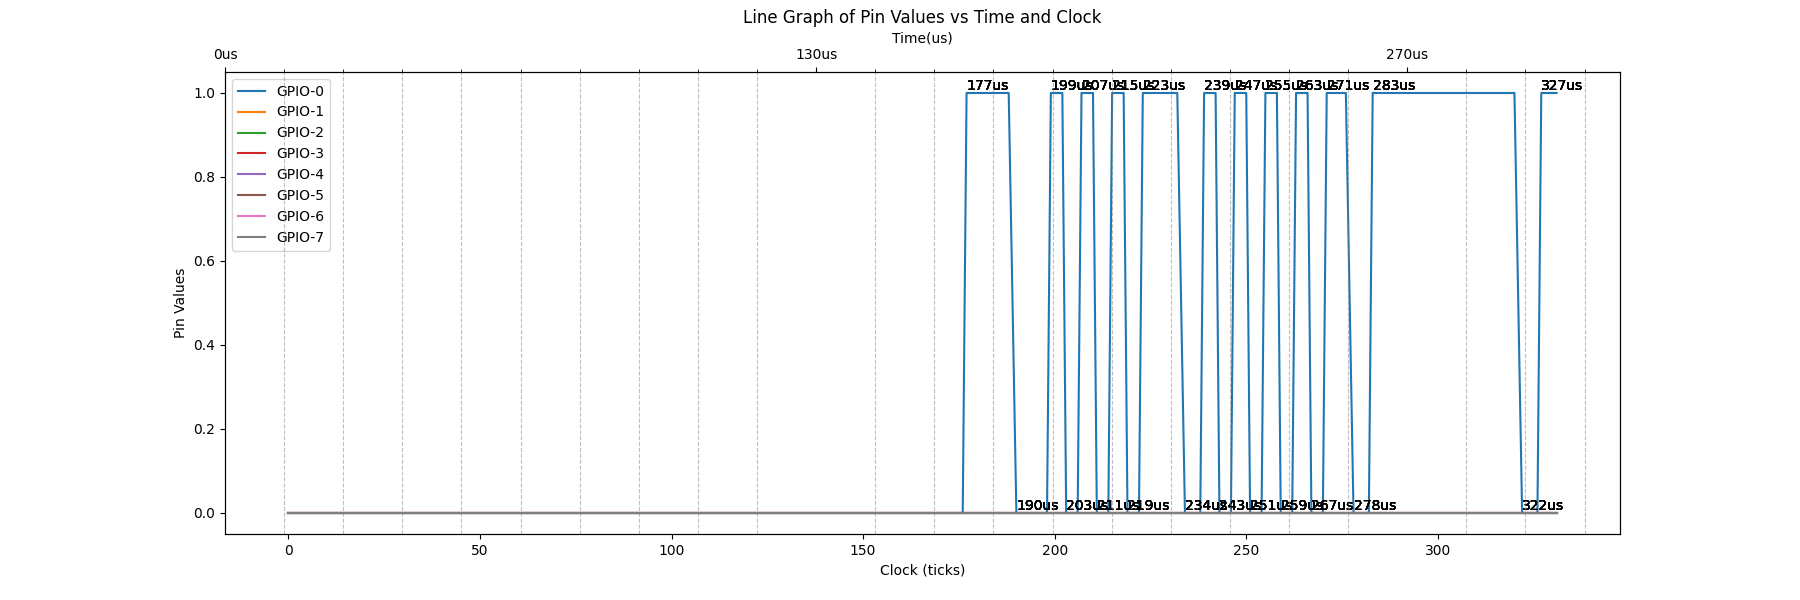

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt

# Extract the clock and pin_values values from the steps list
clock_values = [step[0].clock for step in steps]  # in ticks
pin_values = [step[0].pin_values for step in steps]
time_values = [step[0].clock for step in steps] # in us (1MHz)

# Set the figure size
plt.figure(figsize=(18, 6))



# Add labels and title
plt.xlabel('Clock (ticks)')
plt.ylabel('Pin Values')
plt.title('Line Graph of Pin Values vs Time and Clock')

# Plot for every GPIO based on the bit
for bit in range(8):
    pin_values_bit = [step[0].pin_values & (1 << bit) for step in steps]
    plt.plot(clock_values, pin_values_bit, label=f'GPIO-{bit}')
    for i, val in enumerate(pin_values):
        if i > 0 and val != pin_values[i - 1]:
            plt.text(clock_values[i], val, f"{time_values[i]}us", ha='left', va='bottom')


# Add legend
plt.legend()

# Add a second x-axis for time values
ax2 = plt.twiny()
ax2.set_xlabel('Time(us)')
ax2.set_xlim(0, len(time_values))
ax2.set_xticks([i for i in range(0, len(time_values), 100)])
ax2.set_xticks([i for i in range(0, len(time_values), 10)], minor=True)
ax2.set_xticklabels([f"{time_values[i]}us" for i in range(0, len(time_values), 100)])

# Add vertical grid lines every 4 us
ax2.grid(True, which='minor', axis='x', linestyle='--', color='grey', alpha=0.5)
# Show the graph
plt.show()
